This notebook
* implements k-NN and exemplifies it's use for classification and regression

In [3]:
import numpy as np

In [4]:
import matplotlib
import matplotlib.pyplot as plt

In [5]:
import scipy

In [6]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
import pandas as pd

In [8]:
import seaborn as sns

In [9]:
filepath = './data/'

## supervised learning - `k-Nearest Neighbors (k-NN)` algorithm

* [Victor Lavrenko - Nearest Neighbour Methods](https://www.youtube.com/watch?v=k_7gMp5wh5A&list=PLBv09BD7ez_68OwSB97WXyIOvvI5nqi-3&index=1)

### separating the dataset into training and test

To assess the model's performance, we show it new data (data that it hasn't seen before) for which we have labels. This is usually done by splitting the labeled data we have collected (here, our 150 flower measurements) into two parts. 

* One part of the data is used to build our machine learning model, and is called the training data or training set. 
* The rest of the data will be used to assess how well the model works; this is called the test data, test set, or hold-out set.

scikit-learn contains a function that shuffles the dataset and splits it for you: the `train_test_split()` function

data is usually denoted with a capital X, while labels are denoted by a lowercase y

In [14]:
iris = datasets.load_iris()

In [15]:
# X_train contains 75% of the rows of the dataset, and X_test contains the remaining 25%

X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=0)

# Before making the split, the train_test_split function shuffles the dataset (shuffle=True)
# To make sure that we will get the same output if we run the same function several times, 
# we provide the pseudorandom number generator with a fixed seed using the random_state parameter.

    sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    test_size: float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. 
    If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. 
    If train_size is also None, it will be set to 0.25.

In [17]:
X_train.shape

(112, 4)

In [18]:
y_train.shape

(112,)

In [19]:
X_test.shape

(38, 4)

In [20]:
X_train.shape[0]/(X_train.shape[0] + X_test.shape[0])

0.7466666666666667

### visualizing the dataset

Before building a machine learning model it is often a good idea to inspect the data, to see if the task is easily solvable without machine learning, or if the desired information might not be contained in the data.

Additionally, inspecting your data is a good way to find abnormalities and peculiarities

working with dataframes can be easier

In [21]:
# Convert the training set to a DataFrame for easy manipulation
train_df = pd.DataFrame(X_train, columns=iris['feature_names'])
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.9,3.0,4.2,1.5
1,5.8,2.6,4.0,1.2
2,6.8,3.0,5.5,2.1
3,4.7,3.2,1.3,0.2
4,6.9,3.1,5.1,2.3


In [22]:
# Add the target species as a new column and map the target integers to species names
train_df['species'] = pd.Categorical.from_codes(y_train, iris['target_names'])
train_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.9,3.0,4.2,1.5,versicolor
1,5.8,2.6,4.0,1.2,versicolor
2,6.8,3.0,5.5,2.1,virginica
3,4.7,3.2,1.3,0.2,setosa
4,6.9,3.1,5.1,2.3,virginica


In [23]:
# Create a numeric mapping for the species
# Define the mapping from species to numeric values
species_mapping = {species: index for index, species in enumerate(iris['target_names'])}

# Add the numeric species column using the mapping
train_df['species_numeric'] = train_df['species'].map(species_mapping)
train_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_numeric
0,5.9,3.0,4.2,1.5,versicolor,1
1,5.8,2.6,4.0,1.2,versicolor,1
2,6.8,3.0,5.5,2.1,virginica,2
3,4.7,3.2,1.3,0.2,setosa,0
4,6.9,3.1,5.1,2.3,virginica,2
...,...,...,...,...,...,...
107,4.9,3.1,1.5,0.1,setosa,0
108,6.3,2.9,5.6,1.8,virginica,2
109,5.8,2.7,4.1,1.0,versicolor,1
110,7.7,3.8,6.7,2.2,virginica,2


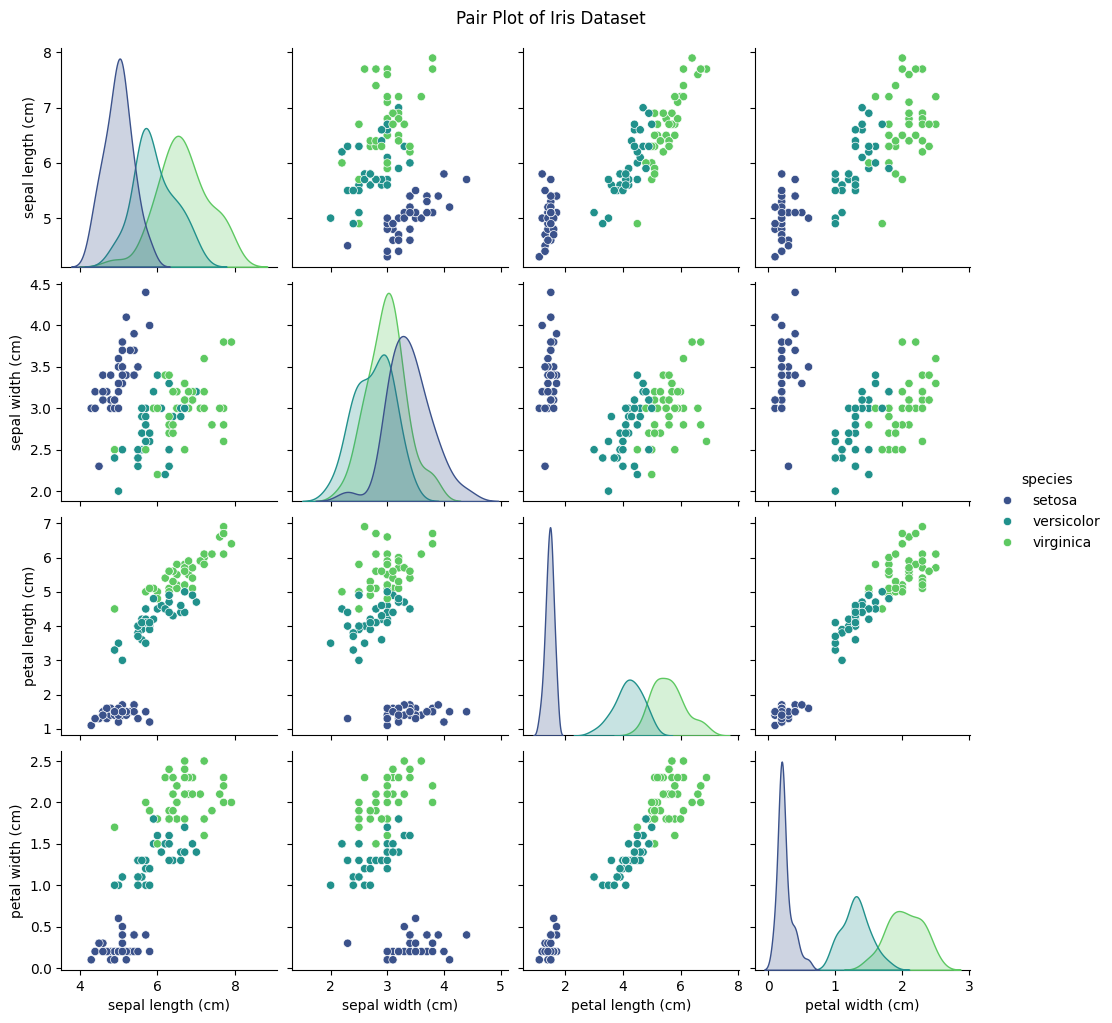

In [25]:
sns.pairplot(train_df, hue='species', palette='viridis')

# Add a title
plt.suptitle('Pair Plot of Iris Dataset', y=1.02)

# Show the plot
plt.show()

From the plots, we can see that the three classes seem to be relatively well separated using the sepal and petal measurements. This means that a machine learning model will likely be able to learn to separate them.

### k-neighbors classification

The `k-Nearest Neighbors (k-NN)` algorithm can be used for classification and regression
* called `k-neighbors classification`
* `k-neighbors regression`

All machine learning models in scikit-learn are implemented in their own classes, which are called Estimator classes. The k-nearest neighbors classification algorithm is implemented in the `KNeighborsClassifier` class in the neighbors module.

The knn object encapsulates the algorithm that will be used to build the model from the training data, as well the algorithm to make predictions on new data points. 

* To make a prediction for a new data point, the algorithm finds the point in the training set that is closest to the new point. Then it assigns the label of this training point to the new data point.
* The k in k-nearest neighbors signifies that instead of using only the closest neighbor to the new data point, we can consider any fixed number k of neighbors in the training (for example, the closest three or five neighbors). Then, we can make a prediction using the majority class among these neighbors.

In [33]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=0)

In [34]:
from sklearn.neighbors import KNeighborsClassifier

**create a classifier object corresponing to a ML model**

In [35]:
knn = KNeighborsClassifier(n_neighbors=1) # num neighboors = 1
knn

KNeighborsClassifier(n_neighbors=1)

**build/train the model using the training set**

In [36]:
knn.fit(X_train, y_train)
# The fit method returns the knn object itself (and modifies it in place)

KNeighborsClassifier(n_neighbors=1)

**make predictions using this model**

In [37]:
# example flower
X_new = np.array([[5, 2.9, 1, 0.2]])

In [38]:
prediction = knn.predict(X_new)
prediction # this is the prediction

array([0])

In [39]:
iris['target_names'][prediction] # this is the predicted target name

array(['setosa'], dtype='<U10')

In [40]:
print("Prediction: {}".format(prediction))
print("Predicted target name: {}".format(iris['target_names'][prediction]))

Prediction: [0]
Predicted target name: ['setosa']


**evaluate the model performance** (against the test dataset)

In [41]:
y_pred = knn.predict(X_test)
y_pred

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2])

$\text{accuracy} = \Large \frac{\text{# correct classifications}}{\text{# all classifications}}$

In [42]:
# compute accuracy
np.sum(y_pred == y_test)/len(y_pred)

np.float64(0.9736842105263158)

In [43]:
np.mean(y_pred == y_test) # same thing

np.float64(0.9736842105263158)

In [44]:
knn.score(X_test, y_test) # same thing

0.9736842105263158

In [45]:
def my_accuracy(y_true, y_pred):
    return np.sum(y_pred == y_test)/len(y_pred)

For this model, the test set accuracy is about 0.97, which means we made the right prediction for 97% of the irises in the test set. This means that we can expect our model to be correct 97% of the time for new irises.

**implementing k-neighbors classification**

* The k-NN algorithm is arguably the simplest machine learning algorithm. Building the model consists only of storing the training dataset. To make a prediction for a new data point, the algorithm finds the closest data points in the training dataset—its "nearest neighbors".

* In its simplest version, the k-NN algorithm only considers exactly one nearest neighbor, which is the closest training data point to the point we want to make a prediction for. The prediction is then simply the known output for this training point.

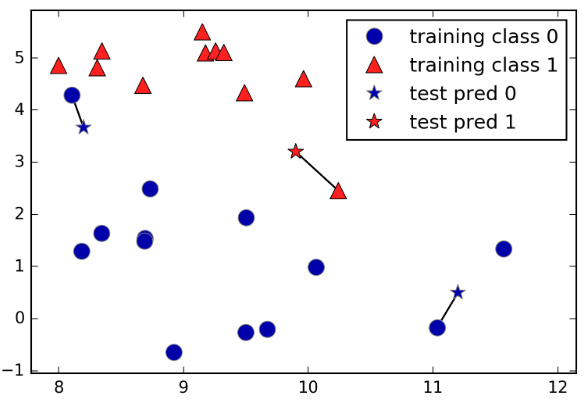

(this figure illustrates the method, using the forge dataset)

In [46]:
# Compute the Euclidean distance between a test sample and all training samples.
# Find the closest neighbor (the one with the minimum distance).
# Assign the label of the closest neighbor to the test sample.

In [47]:
import numpy as np
# from sklearn.datasets import load_breast_cancer
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [48]:
# Step 1: Load the dataset
cancer = datasets.load_breast_cancer()
X, y = cancer.data, cancer.target

In [49]:
# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for two points $x_1 = (x_{1,1}, x_{1,2}, \ldots, x_{1,n})$ and $x_2 = (x_{2,1}, x_{2,2}, \ldots, x_{2,n})$ the euclidian distance is

\begin{align}
d = \sqrt{\sum_{i=1}^n (x_{2,i} - x_{1,i})^2}
\end{align}

In [50]:
# function to compute the Euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [51]:
# 1-NN classification function
def knn_predict(X_train, y_train, X_test):
    y_pred = []
    for test_point in X_test:
        # Compute the distance between test_point and all training points
        distances = [euclidean_distance(test_point, x_train) for x_train in X_train]
        
        # Find the index of the closest training point
        min_index = np.argmin(distances)
        
        # Assign the label of the nearest neighbor
        y_pred.append(y_train[min_index])
    
    return np.array(y_pred)

In [52]:
# Step 3: Make predictions on the test set
y_pred = knn_predict(X_train, y_train, X_test)

In [53]:
# Step 4: Calculate the accuracy
accuracy = my_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 92.98%


In [54]:
# compare it with sklearn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9298245614035088

* Instead of considering only the closest neighbor, we can also consider an arbitrary number, k, of neighbors.
When considering more than one neighbor, we use voting to assign a label. This means that for each test point, we count how many neighbors belong to class 0 and how many neighbors belong to class 1. We then assign the class that is more frequent: in other words, the majority class among the k-nearest neighbors.

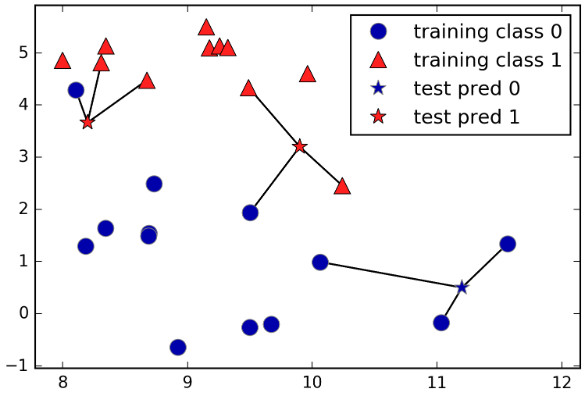

In [55]:
# Compute the distances between the test sample and all training samples.
# Find the K nearest neighbors (the K smallest distances).
# Perform majority voting among the labels of those K neighbors to assign a label to the test sample.

In [56]:
# from collections import Counter

In [57]:
cancer = datasets.load_breast_cancer()
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Function to find the most common label (manual counting)
def majority_vote(labels):
    unique_labels = np.unique(labels)  # Find unique labels
    label_counts = np.zeros(len(unique_labels))  # Initialize counts
    
    # Count occurrences of each label
    for label in labels:
        label_counts[np.where(unique_labels == label)] += 1
    
    # Find the label with the highest count
    majority_label = unique_labels[np.argmax(label_counts)]
    return majority_label

In [59]:
# KNN classification function
def knn_predict(X_train, y_train, X_test, k=1):
    y_pred = []
    for test_point in X_test:
        # Compute the distance between test_point and all training points
        distances = [euclidean_distance(test_point, x_train) for x_train in X_train]
        
        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:k]
        
        # Get the labels of the k nearest neighbors
        k_nearest_labels = [y_train[i] for i in k_indices]
        
        # Majority voting: the most common label in the k neighbors
        # most_common = Counter(k_nearest_labels).most_common(1)[0][0]
        most_common = majority_vote(k_nearest_labels)
        
        # Append the predicted label
        y_pred.append(most_common)
    
    return np.array(y_pred)

In [60]:
k = 5  # You can change this to any k-value
y_pred = knn_predict(X_train, y_train, X_test, k=k)

In [61]:
accuracy = my_accuracy(y_test, y_pred)
print(f"Accuracy with k={k}: {accuracy * 100:.2f}%")

Accuracy with k=5: 95.61%


In [62]:
# compare it with sklearn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.956140350877193

* For two-dimensional datasets, we can also illustrate the prediction for all possible test points in the xy-plane. We color the plane according to the class that would be assigned to a point in this region. This lets us view the `decision boundary`, which is the divide between where the algorithm assigns class 0 versus where it assigns class 1.

In [68]:
def make_forge():
    # a carefully hand-designed dataset lol
    X, y = datasets.make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

In [69]:
X, y = make_forge()

In [70]:
import matplotlib
cm2 = matplotlib.colors.ListedColormap(['#0000aa', '#ff2020'])
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,
                      cm=cm2, linewidth=None, threshold=None,
                      linestyle="solid"):
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [
            decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

NameError: name 'discrete_scatter' is not defined

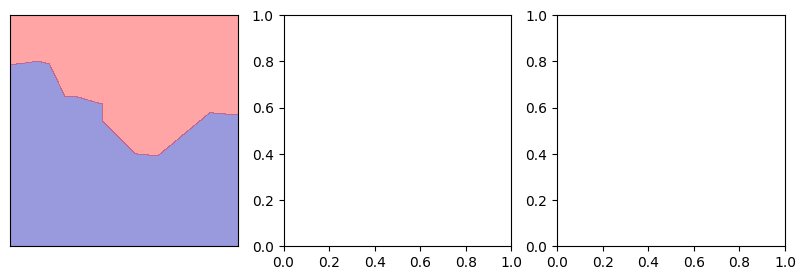

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for n_neighbors, ax in zip([1, 3, 9], axes):
    # the fit method returns the object self, so we can instantiate
    # and fit in one line
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1")
axes[0].legend(loc=3)

How do we choose the parameter value?

In [ ]:
# evaluate training and test set performance with different numbers of neighbors
cancer = datasets.load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify=cancer.target, random_state=66)
# The stratify parameter in train_test_split ensures that the proportion of classes (labels) in the training
# and testing datasets is the same as in the original dataset. 
# This is particularly useful when you have imbalanced datasets, where one class is significantly more frequent 
# than the other(s)

In [72]:
training_accuracy = []
test_accuracy = []

In [73]:
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

In [74]:
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))

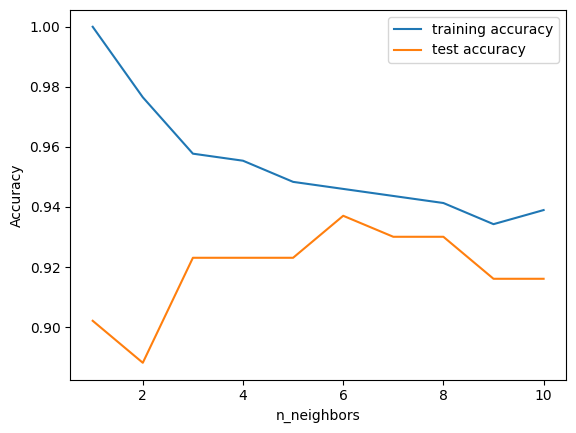

In [75]:
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

* Considering a single nearest neighbor, the prediction on the training set is perfect. But when more neighbors are considered, the model becomes simpler and the training accuracy drops. The test set accuracy for using a single neighbor is lower than when using more neighbors, indicating that using the single nearest neighbor leads to a model that is too complex. On the other hand, when considering 10 neighbors, the model is too simple and performance is even worse. The best performance is somewhere in the middle, using around six neighbors. Still, it is good to keep the scale of the plot in mind. The worst performance is around 88% accuracy, which might still be acceptable.

### k-neighbors regression

instead of classifying based on a majority vote of the nearest neighbors' labels, we will predict the output as the value of the nearest neighbor for the regression task.

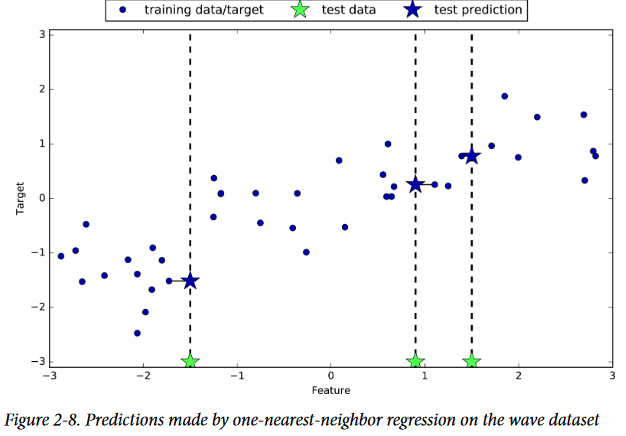

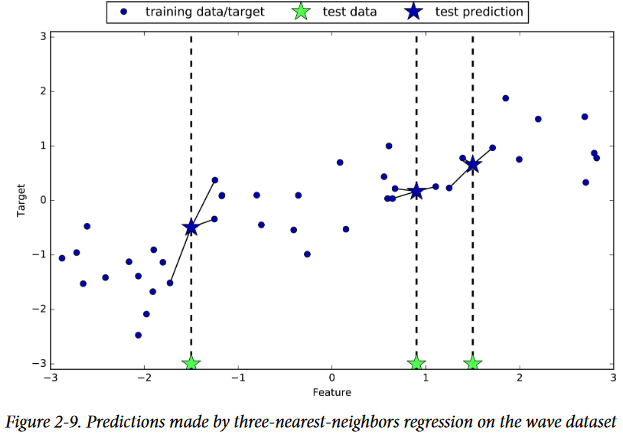

In [76]:
# 1-NN Regression
# Compute the distances between the test sample and all training samples.
# Find the closest neighbor (the one with the smallest distance).
# Predict the output as the value (in the case of regression, the numeric output) of the closest neighbor.

In [77]:
X, y = datasets.make_regression(n_samples=100, n_features=1, noise=10, random_state=42)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# 1-NN regression prediction function
def knn_regression_predict(X_train, y_train, X_test):
    y_pred = []
    for test_point in X_test:
        # Compute the distance between test_point and all training points
        distances = [euclidean_distance(test_point, x_train) for x_train in X_train]
        
        # Find the index of the nearest neighbor
        min_index = np.argmin(distances)
        
        # Assign the output of the nearest neighbor as the prediction  # <----------------------------------CHANGE
        y_pred.append(y_train[min_index])
    
    return np.array(y_pred)

In [80]:
y_pred = knn_regression_predict(X_train, y_train, X_test)
y_pred

array([-63.16609268,  64.57600193,  51.39997923,   9.31786907,
       -29.99628354, -20.19870331, -30.06888275, -78.59179131,
        51.39997923,  28.57973536,  49.68666288,  22.78482382,
       -62.09952962, -20.69551487, -44.43130901, -19.78188548,
        47.8357159 ,   5.76708113,  46.0731574 ,   7.58329135])

There is no "correct" or "wrong" predictions now, since we predict real values
* The $R^2$ score, also known as the `coefficient of determination`, 
is a measure of goodness of a prediction for a regression model, and yields a score between 0 and 1. A value of 1 corresponds to a perfect prediction, and a value of 0 corresponds to a constant model that just predicts the mean of the training set responses, y_train
* the `mean squared error (MSE)` or `mean squared deviation (MSD)`
of an estimator (of a procedure for estimating an unobserved quantity) measures the average of the squares of the errors

\begin{align}
R^2 = 1 - \frac{\text{SS}_{res}}{\text{SS}_{tot}} \\
\end{align}

$\text{SS}_{res}$ (Residual sum of squares) is the sum of the squared differences between the actual values $y_i$ and the predicted values $\hat{y_i}$
\begin{align}
= \sum_{i=1}^n (y_i - \hat{y_i})^2
\end{align}

$\text{SS}_{tot}$ (Total sum of squares) is the sum of the squared differences between the actual values and the mean of the actual values $\bar{y_i}$

\begin{align}
= \sum_{i=1}^n (y_i - \bar{y_i})^2
\end{align}

In [81]:
# Calculate the coefficient of determination (R^2)
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)  # Coefficient of determination

In [82]:
print(f"R^2: {r_squared(y_test, y_pred):.2f}")

R^2: 0.86


\begin{align}
\text{MSE} = \frac{1}{n} \text{SS}_{res} = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y_i})^2
\end{align}

In [83]:
def my_mse(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

In [84]:
print(f"MSE: {my_mse(y_test, y_pred):.2f}")

MSE: 226.23


compare it with sklearn

In [85]:
from sklearn.neighbors import KNeighborsRegressor

In [86]:
# instantiate the model and set the number of neighbors to consider to 1
reg = KNeighborsRegressor(n_neighbors=1)
# fit the model using the training data and training targets
reg.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

In [87]:
reg.score(X_test, y_test)

0.8641248557739871

In [88]:
# k-NN Regression
# Compute the distances between the test sample and all training samples.
# Find the K nearest neighbors (i.e., the K samples with the smallest distances).
# Predict the output by averaging the output values of these K nearest neighbors.

In [89]:
# General K-NN regression prediction function
def knn_regression_predict(X_train, y_train, X_test, k=1):
    y_pred = []
    for test_point in X_test:
        # Compute the distance between the test_point and all training points
        distances = [euclidean_distance(test_point, x_train) for x_train in X_train]
        
        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:k]
        
        # Get the outputs (target values) of the k nearest neighbors
        k_nearest_outputs = [y_train[i] for i in k_indices]
        
        # Predict the output as the average of the k nearest outputs # <----------------------------------CHANGE
        y_pred.append(np.mean(k_nearest_outputs))
    
    return np.array(y_pred)

In [90]:
k = 5  # You can change this value of k
y_pred = knn_regression_predict(X_train, y_train, X_test, k=k)

In [91]:
print(f"R^2: {r_squared(y_test, y_pred):.3f}")

R^2: 0.935


compare it with sklearn

In [92]:
# instantiate the model and set the number of neighbors to consider to 5
reg = KNeighborsRegressor(n_neighbors=5)
# fit the model using the training data and training targets
reg.fit(X_train, y_train)

KNeighborsRegressor()

In [93]:
reg.score(X_test, y_test)

0.9350489024280596

### oop implementation

in every ML algorithm you can identify and separate:
* a phase where you build/train/fit a model
* a phase where you use the model (to make predictions and test the model performance)

K-Nearest Neighbors (KNN) is a `lazy learning algorithm`, meaning it doesn't explicitly "train" a model like other algorithms (e.g., decision trees, neural networks). Instead, it simply stores the training data and computes distances to the training points at prediction time.

That being said, we can structure your code into two parts:
* a train() function, which just stores the training data.
* a predict() function, which uses the stored training data to make predictions.

In [94]:
# KNN 'train' function
def train(X_train, y_train):
    """
    This function 'trains' the KNN model.
    For KNN, training is just storing the training data.
    """
    return X_train, y_train

In [95]:
# KNN classification 'predict' function
def knn_classification_predict(X_train, y_train, X_test, k=1):
    """
    This function predicts the labels for the test set using the KNN algorithm.
    It calculates the distances from each test point to the training points,
    finds the k-nearest neighbors, and performs majority voting.
    """
    y_pred = []
    for test_point in X_test:
        # Compute the distance between test_point and all training points
        distances = [euclidean_distance(test_point, x_train) for x_train in X_train]
        
        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:k]
        
        # Get the labels of the k nearest neighbors
        k_nearest_labels = [y_train[i] for i in k_indices]
        
        # Majority voting: the most common label in the k neighbors
        most_common = majority_vote(k_nearest_labels)
        
        # Append the predicted label
        y_pred.append(most_common)
    
    return np.array(y_pred)

In [96]:
# Train data
X_train = np.array([[1, 2], [2, 3], [3, 4], [6, 8]])
y_train = np.array([0, 0, 1, 1])

# Test data
X_test = np.array([[1, 1], [5, 6]])

# Training (simply storing the data for KNN)
X_train, y_train = train(X_train, y_train)

# Predicting
k = 3
predictions = knn_classification_predict(X_train, y_train, X_test, k)
print("Predictions:", predictions)

Predictions: [0 1]


In [97]:
# KNN regression 'predict' function
def knn_regression_predict(X_train, y_train, X_test, k=1):
    y_pred = []
    for test_point in X_test:
        # Compute the distance between the test_point and all training points
        distances = [euclidean_distance(test_point, x_train) for x_train in X_train]
        
        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:k]
        
        # Get the outputs (target values) of the k nearest neighbors
        k_nearest_outputs = [y_train[i] for i in k_indices]
        
        # Predict the output as the average of the k nearest outputs # <----------------------------------CHANGE
        y_pred.append(np.mean(k_nearest_outputs))
    
    return np.array(y_pred)

next i can create a class for each of the models, and that class can implement methods from a abstract class or an interface.
If you plan to implement a common method (like `score()`) that will be shared across all classifiers and regressors, then using abstract classes is a better choice. Abstract classes allow you to define some shared functionality (like `score()`), while still enforcing that subclasses implement specific methods (like `train()` and `predict()`)

In [98]:
from abc import ABC, abstractmethod # for abstract classes and interfaces

In [99]:
# Abstract class for Classifier
class Classifier(ABC):
    
    @abstractmethod
    def train(self, X_train, y_train):
        """
        Train the model with X_train and y_train data.
        """
        pass
    
    @abstractmethod
    def predict(self, X_test):
        """
        Predict the labels for X_test data.
        """
        pass

    def score(self, X_test, y_test):
        """
        Compute the accuracy score: the proportion of correctly classified samples.
        """
        y_pred = self.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / len(y_test)
        return accuracy

In [100]:
# Abstract class for Regressor
class Regressor(ABC):
    
    @abstractmethod
    def train(self, X_train, y_train):
        """
        Train the model with X_train and y_train data.
        """
        pass
    
    @abstractmethod
    def predict(self, X_test):
        """
        Predict the values for X_test data.
        """
        pass

    def score(self, X_test, y_test):
        """
        Compute the R² (coefficient of determination) score.
        """
        y_pred = self.predict(X_test)
        ss_res = np.sum((y_test - y_pred) ** 2)  # Residual sum of squares
        ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)  # Total sum of squares
        r2_score = 1 - (ss_res / ss_tot)
        return r2_score

In [101]:
# KNN Classifier implementation
class my_KNeighborsClassifier(Classifier):
    
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def train(self, X_train, y_train):
        """
        Store the training data (KNN doesn't actually train).
        """
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test):
        """
        Predict labels for the test data using the KNN algorithm.
        """
        y_pred = []
        for test_point in X_test:
            # Compute the distance between test_point and all training points
            distances = [euclidean_distance(test_point, x_train) for x_train in self.X_train]
            
            # Get the indices of the k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            
            # Get the labels of the k nearest neighbors
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            
            # Majority voting: the most common label in the k neighbors
            most_common = max(set(k_nearest_labels), key=k_nearest_labels.count)
            
            # Append the predicted label
            y_pred.append(most_common)
        
        return np.array(y_pred)

In [102]:
# KNN Regressor implementation
class my_KNeighborsRegressor(Regressor):
    
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def train(self, X_train, y_train):
        """
        Store the training data (KNN doesn't actually train).
        """
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test):
        """
        Predict values for the test data using the KNN algorithm.
        For regression, we compute the mean of the nearest neighbors' values.
        """
        y_pred = []
        for test_point in X_test:
            # Compute the distance between test_point and all training points
            distances = [euclidean_distance(test_point, x_train) for x_train in self.X_train]
            
            # Get the indices of the k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            
            # Get the values of the k nearest neighbors
            k_nearest_values = [self.y_train[i] for i in k_indices]
            
            # Take the mean of the nearest neighbors' values
            mean_value = np.mean(k_nearest_values)
            
            # Append the predicted value
            y_pred.append(mean_value)
        
        return np.array(y_pred)

In [103]:
# Example usage of KNN Classifier
X_train_class = np.array([[1, 2], [2, 3], [3, 4], [6, 8]])
y_train_class = np.array([0, 0, 1, 1])

X_test_class = np.array([[1, 1], [5, 6]])
y_test_class = np.array([0, 1])

knn_classifier = my_KNeighborsClassifier(k=3)
knn_classifier.train(X_train_class, y_train_class)
predictions_class = knn_classifier.predict(X_test_class)
accuracy = knn_classifier.score(X_test_class, y_test_class)
print("KNN Classifier Predictions:", predictions_class)
print("Classifier Accuracy:", accuracy)

KNN Classifier Predictions: [0 1]
Classifier Accuracy: 1.0


In [104]:
# Example usage of KNN Regressor
X_train_reg = np.array([[1, 2], [2, 3], [3, 4], [6, 8]])
y_train_reg = np.array([1.5, 2.0, 2.5, 7.0])

X_test_reg = np.array([[1, 1], [5, 6]])
y_test_reg = np.array([1.0, 6.0])

knn_regressor = my_KNeighborsRegressor(k=3)
knn_regressor.train(X_train_reg, y_train_reg)
predictions_reg = knn_regressor.predict(X_test_reg)
r2_score = knn_regressor.score(X_test_reg, y_test_reg)
print("KNN Regressor Predictions:", predictions_reg)
print("Regressor R² Score:", r2_score)

KNN Regressor Predictions: [2.         3.83333333]
Regressor R² Score: 0.5444444444444445


Next you'd put both models into a `neighbors` module and the rest are advanced math/optimization/options things

### mathematical formulation

A dataset $\mathcal{D}$ in supervised learning consists of $n$ data points (examples or observations), where each data point has:
* A feature vector $x_i = (x_{i1}, x_{i2}, \ldots, x_{id}) \in \mathbb{R}^d$,  which is a d-dimensional vector containing the features or input variables
* A corresponding label or target $y_i$ which is the desired output (either a class label in classification or a continuous value in regression)

So $\mathcal{D} = \{ (x_i, y_i)\}_{i=1}^n$

The input can be thought as a table/matrix (input feature matrix) with $n$ rows and $d$ columns 

$
\mathbf{X} =
\begin{pmatrix}
x_{11} & x_{12} & \ldots & x_{1d}\\
x_{21} & x_{22} & \ldots & x_{2d}\\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \ldots & x_{nd}\\
\end{pmatrix}
$

and the output as a matrix with $n$ rows and $1$ column (a column-vector), the output label or target vector 

$
\mathbf{y} = \begin{pmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{pmatrix}
$

Types of labels
* for classification
    * $y_i \in \{1, 2, \ldots, C\}$ for a classification problem with $C$ classes.
    * $y_i \in \{0, 1\}$ for binary classification
* for regression
    * $y_i \in \mathbb{R}$ (a continuous value) for a regression problem

**knn for classification**

In KNN classification, the goal is to predict the class label for a given input x based on the majority class of its k-nearest neighbors

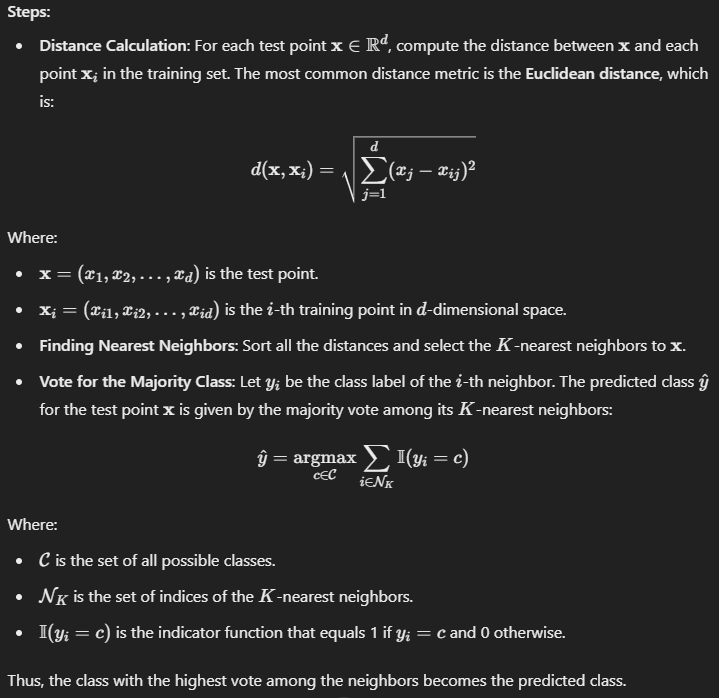

**knn for regression**

the goal is to predict a continuous value for a given input x based on the average (or weighted average) of the values of its 
k-nearest neighbors

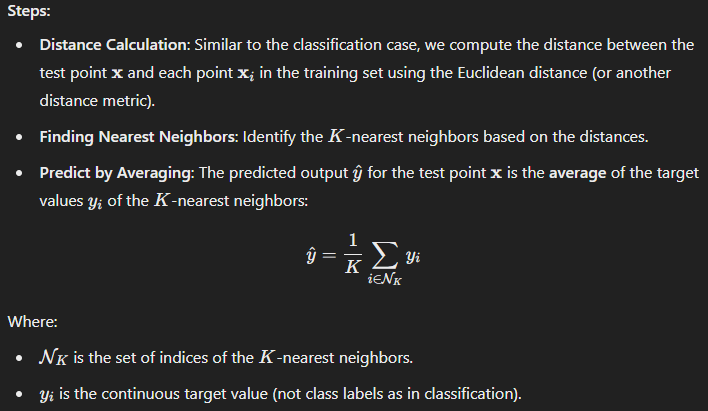

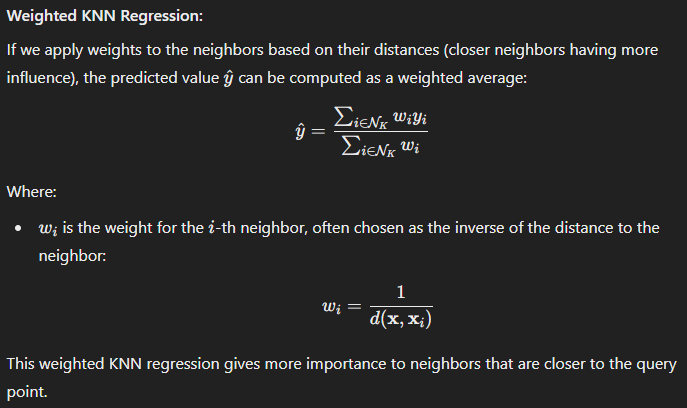

### summary

algorithm parameters:
* k (number of neighbors)

This is the most important parameter. It defines how many nearest neighbors will be considered when making predictions.
A small value of k (like 1) may lead to overfitting, while a large value can lead to underfitting.

* distance metric

    KNN can use various distance metrics to measure the distance between data points. Common distance metrics include:

    * Euclidean distance: The most common distance metric, suitable for continuous variables.
    * Manhattan distance: Useful when dealing with high-dimensional spaces or when the scale of the variables is very different.
    * Minkowski distance: A generalization of both Euclidean and Manhattan distances, defined by a parameter p.
    * Hamming distance: Used for categorical variables (i.e., measuring the difference between two strings).

* weighting of neighbors

    KNN can either treat all neighbors equally or weight them based on their distance to the query point.
    * uniform weights: Each neighbor contributes equally to the prediction.
    * distance-weighted: Closer neighbors contribute more to the prediction than farther neighbors, which can be beneficial in many scenarios.
* algorithm
    Different algorithms can be used to compute the nearest neighbors:
    * Brute Force: Computes the distance to all training samples; useful for smaller datasets.
    * KD-Tree: A space-partitioning data structure that can speed up the search for nearest neighbors in lower-dimensional spaces.
    * Ball Tree: Another data structure optimized for higher dimensions.

* p (for Minkowski distance):

    The power parameter p determines the type of distance metric used:
    * p=1: Manhattan distance
    * p=2: Euclidean distance
    * Other values correspond to different metrics.

`class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)`

`class sklearn.neighbors.KNeighborsRegressor(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)`

https://scikit-learn.org/stable/modules/neighbors.html

strengths:
* simplicity and versatility

    KNN is easy to understand and implement, making it a good choice for beginners in machine learning.
    
    KNN can be used for both classification and regression tasks.

* no assumptions about data

    KNN is a `non-parametric method`, meaning it does not assume anything about the underlying data distribution. It can work well with various data types and distributions.

* incremental learning

    KNN can easily accommodate new data by simply adding it to the dataset without the need to retrain the model.

weaknesses:
* computationally intensive

    KNN requires calculating the distance between the query point and all points in the training dataset, which can be slow, especially for large datasets

* storage requirements

    KNN must store the entire training dataset in memory, which can be a limitation for large datasets.
    
* sensitive to irrelevant features

    The presence of irrelevant or redundant features can negatively impact the performance of KNN, as it relies on distance metrics.

* `Curse of Dimensionality`

    KNN's performance can degrade with high-dimensional data (i.e., when the number of features is large), as the distance between points becomes less meaningful.
    
* Choice of k

    Choosing the right value of k is crucial and may require experimentation. A poor choice can lead to overfitting or underfitting.